In [297]:
# En esta celda se puede probar la funcion de analisis de una imagen

from lib.image import image_data
from lib.analysis import dyssynchrony_analysis
import cv2

# Path completo donde esta la imagen (incluyendo nombre y extencion)
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/seleccion/170719SEL/170719Dan8/'
photo_name = 'dan8a000'
photo = photo_name + '.tif'
# Ancho de la feta a analisar (es un parametro opcional)
slice_width = 5

# Distancia minima en pixeles entre picos
min_dist_between_maxs = 200

# Calibracion del tiempo de cada pixel
calibration = 4.5

image = cv2.imread(path + photo_name + '.tif')
# Select ROI
fromCenter = False
showCrosshair = False
seleted_parameters = cv2.selectROI(image, fromCenter, showCrosshair)

# Crop image
x_start = int(seleted_parameters[1])
x_end = x_start + int(seleted_parameters[3])
y_start = int(seleted_parameters[0])
y_end = y_start + int(seleted_parameters[2])

cv2.destroyAllWindows()

image = image_data.get_image_data(image)
image = image_data.crop_vertical(image, x_start, x_end)
image = image_data.crop_horizontal(image, y_start, y_end)

results = dyssynchrony_analysis.analyze_image(image, min_dist_between_maxs, calibration, slice_width=slice_width)

In [298]:
jasonGenerator(path,results,photo_name)

In [299]:
slicesParser_amplitudes(path)

,transient1,transient2
1,2.541667,2.347826
2,2.583333,2.391304
3,2.375000,2.173913
4,2.260870,2.090909
5,2.086957,2.000000
6,2.086957,1.826087
7,2.260870,1.826087
8,2.478261,1.909091
9,2.636364,2.142857
10,2.545455,2.500000


In [278]:
print(results['image']['max_peaks_positions'])
for i in range(0,len(results['slices'])):
    array = results['slices'][i]['max_peaks_positions']
    print(i,array)

[22, 69, 115, 165, 209, 255]
0 [36, 67, 114, 163, 205, 260]
1 [29, 60, 115, 163, 210, 257]
2 [28, 67, 118, 166, 209, 257]
3 [22, 70, 118, 165, 214, 258]
4 [22, 68, 120, 161, 214, 255]
5 [21, 67, 119, 167, 216, 255]
6 [21, 74, 125, 166, 215, 255]
7 [29, 73, 120, 165, 209, 258]
8 [28, 69, 114, 165, 208, 255]
9 [25, 69, 116, 165, 207, 255]
10 [26, 69, 114, 163, 207, 255]
11 [22, 67, 115, 168, 208, 257]
12 [23, 67, 112, 169, 208, 255]
13 [19, 67, 112, 170, 209, 255]
14 [17, 68, 115, 165, 209, 254]
15 [16, 66, 115, 161, 209, 255]
16 [22, 66, 113, 162, 207, 255]
17 [20, 67, 113, 162, 207, 256]
18 [19, 70, 113, 165, 218, 255]
19 [30, 68, 115, 165, 227, 271]
20 [33, 69, 115, 165, 227, 259]
21 [26, 72, 114, 163, 227, 263]
22 [28, 65, 119, 161, 215, 255]
23 [21, 67, 118, 160, 215, 254]
24 [23, 73, 122, 157, 190, 221, 255]
25 [27, 70, 126, 157, 226, 258]
26 [26, 73, 131, 165, 218, 265]
27 [31, 76, 131, 165, 207, 239, 274]
28 [20, 76, 108, 156, 211, 245, 276]


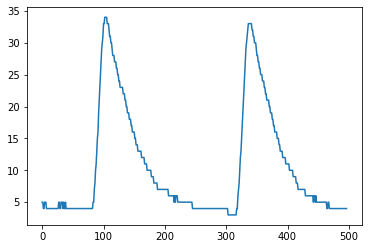

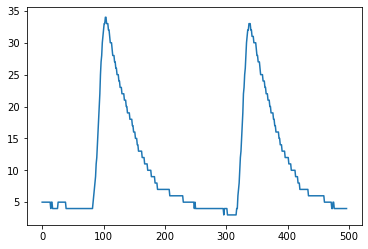

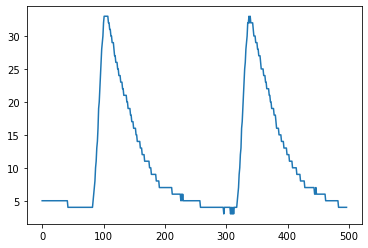

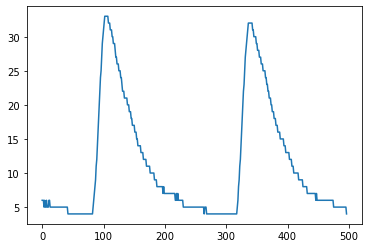

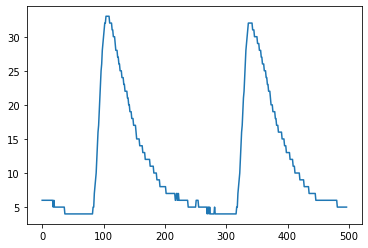

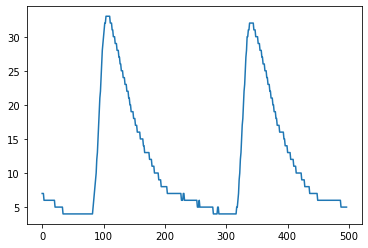

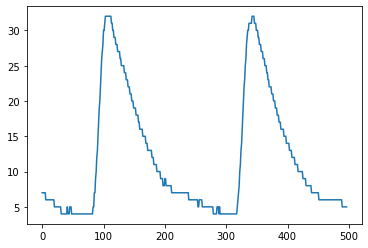

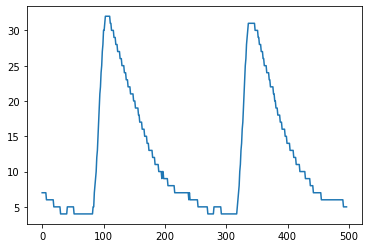

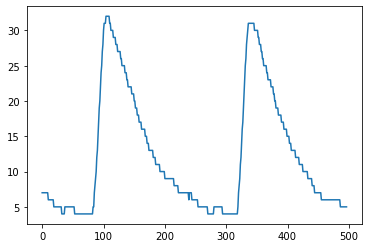

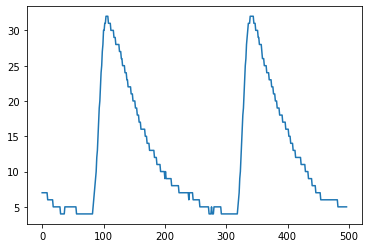

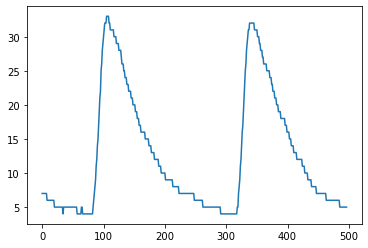

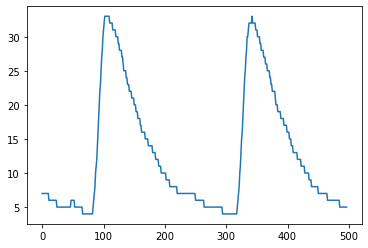

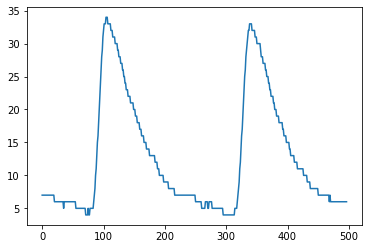

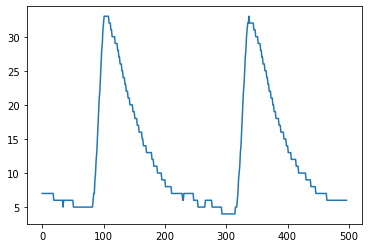

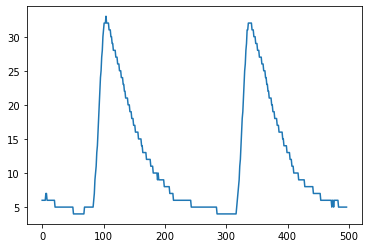

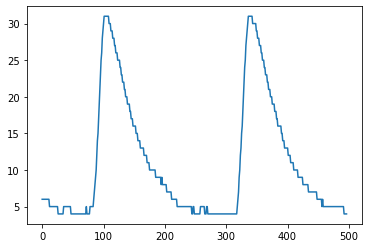

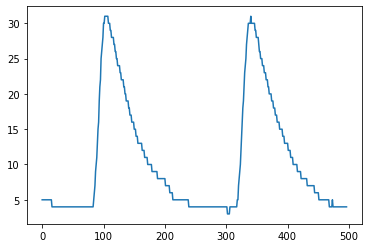

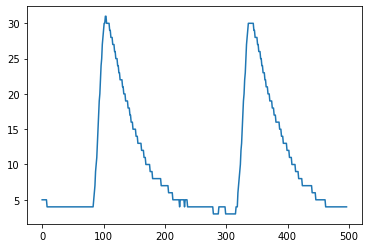

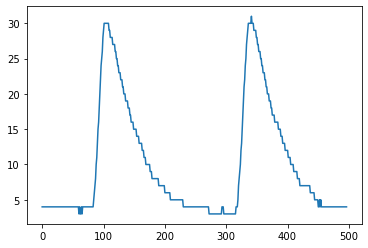

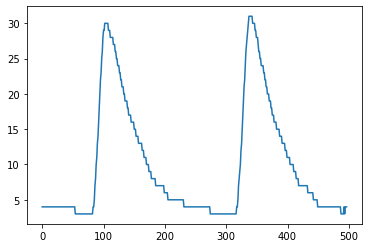

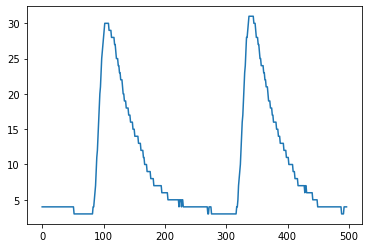

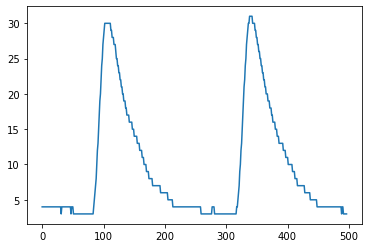

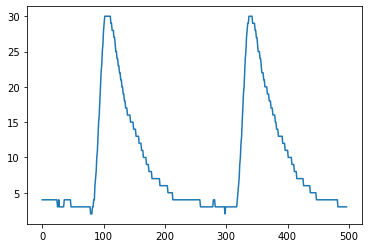

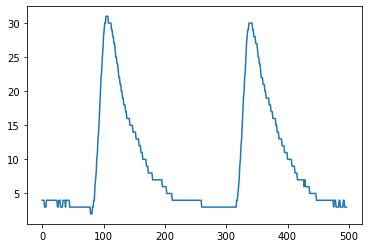

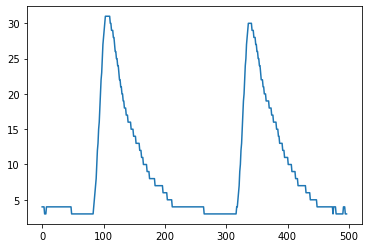

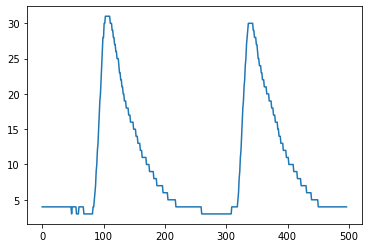

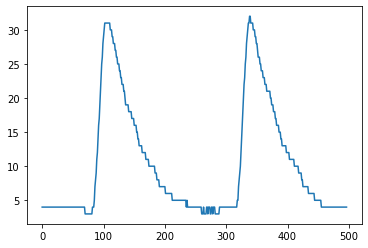

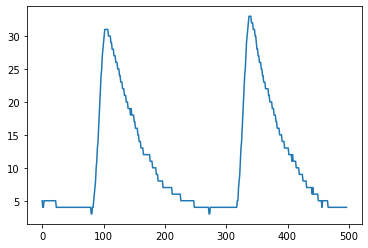

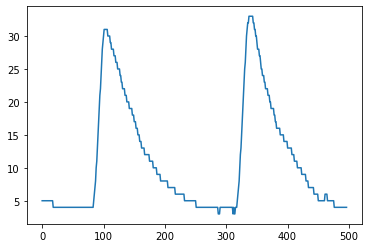

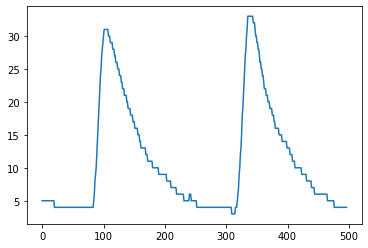

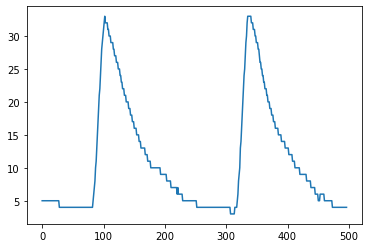

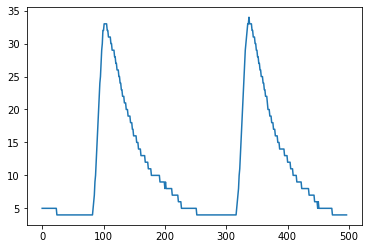

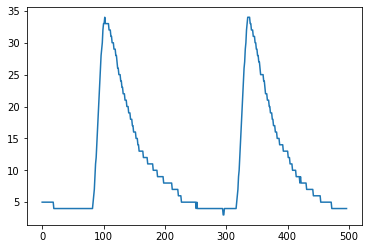

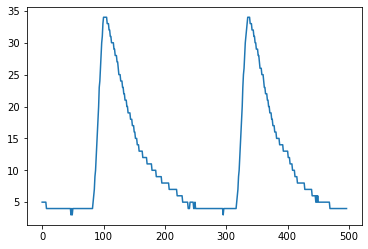

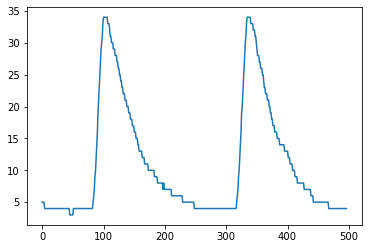

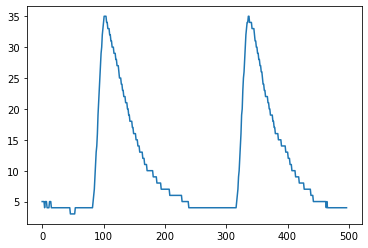

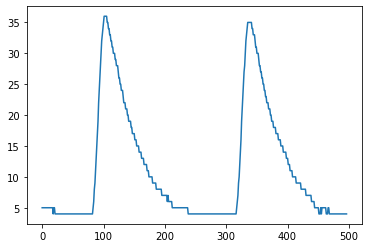

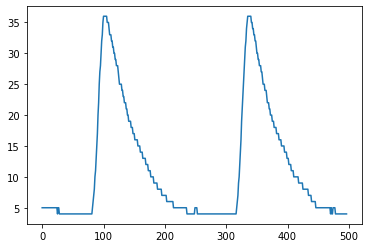

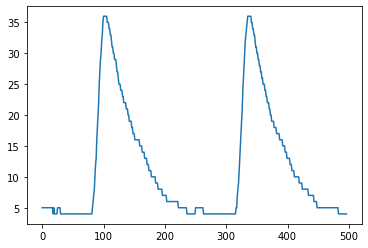

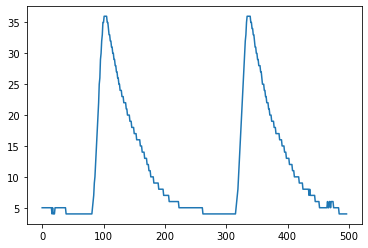

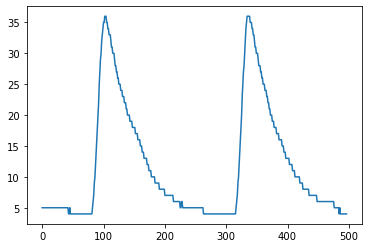

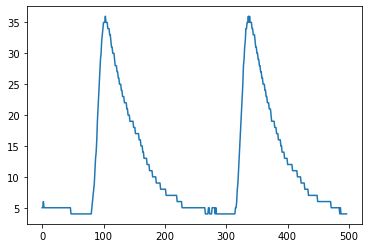

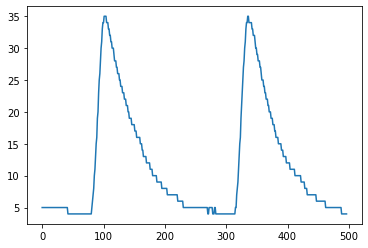

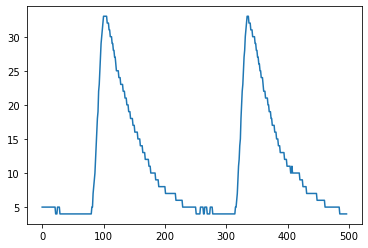

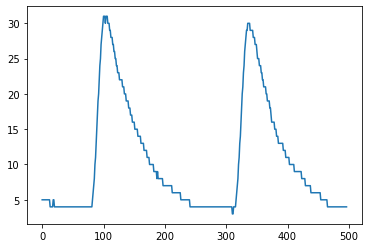

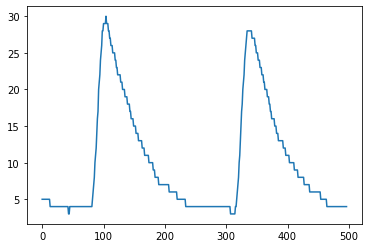

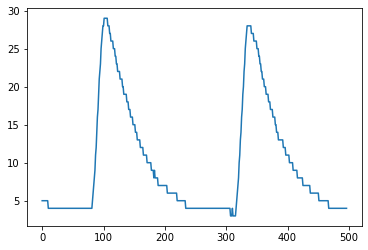

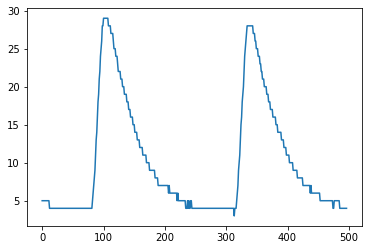

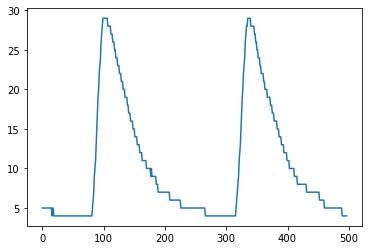

In [202]:
import matplotlib.pyplot as plt

for i in range(0,len(results['slices'])):
    array = results['slices'][i]['intensities']
    plt.plot(array) # plotting by columns
    plt.show()

# PRUEBA ANALISIS 

In [ ]:
# En esta celda se puede probar la funcion de analisis todas las imagenes .tif en un directorio
import os
from lib.image import image_data
from lib.analysis import dyssynchrony_analysis
import cv2

# Ancho de la feta a analisar (es un parametro opcional)
slice_width = 5

# Distancia minima en pixeles entre picos
min_dist_between_maxs = 200

# Calibracion del tiempo de cada pixel
calibration = 3.1

# Path donde estan las imagenes
path = "C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/1 Hz/"

images_paths = [ f'{path}/{file}' for file in os.listdir(path) if file.endswith(".tif") ]
images = [ cv2.imread(image_path) for image_path in images_paths ]

In [ ]:
fromCenter = False
showCrosshair = False

#Tomamos la primer imagen para seleccionar el recorte elegido el resto de las imagenes se van a recortar igual
seleted_parameters = cv2.selectROI(images[0], fromCenter, showCrosshair)

# Crop image
x_start = int(seleted_parameters[1])
x_end = x_start + int(seleted_parameters[3])
y_start = int(seleted_parameters[0])
y_end = y_start + int(seleted_parameters[2])

cv2.destroyAllWindows()

In [ ]:
images = [ image_data.get_image_data(image) for image in images ]
images = [ image_data.crop_vertical(image, x_start, x_end) for image in images ]
images = [ image_data.crop_horizontal(image, y_start, y_end) for image in images ]

In [ ]:
results = [(dyssynchrony_analysis.analyze_image(image, min_dist_between_maxs, calibration, slice_width=5), print ('Done')) for image in images]

# Analisis de datos
Notas: 
- Image corresponde al análisis de toda la célula y slices corresponde a fetas de esa imagen
- intensidades es el valor que resulta de comprimir (sumando) la matriz con las coordenadas de x,y,z de los pixeles 
- max_peaks_pos es la index de en la lista de intensidades 
- max_peaks_intensities el valor de intensidad que se corresponde con el pico en la posicion analoga de max_peaks_pos

In [1]:
#Imports
import json
import numpy as np
import pandas as pd

In [2]:
#encodes a dictionary into a jason
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def jasonGenerator(path,results,photo_name):
    """ Generates a .jason file in the path given folder from the a dictionary """
    with open(path + '/analysis_result_' + photo_name + '.json',"w") as miarch:
        miarch.write(json.dumps(results, cls=NumpyEncoder))

In [3]:
def jasonReader(path, photo):
    """ Reads the .jason generated with jasonGenartor the given path"""
    with open( path + 'analysis_result_' + photo+ '.json','r') as miarch:
        loaded_dict = json.loads(miarch.read())
    return loaded_dict

In [4]:
def slicesParser_max_peaksI(path):
#     read the analysis result 
    dictres = jasonReader(path,photo_name)

#extract all the slices data
    allSlices = dictres['slices']
    try:
        #seting columns names
        column_names = ['transient' + str(x) for x in range(0,len(allSlices[0]['max_peaks_intensities']))]    
        #define a dataframe
        df_sum = pd.DataFrame(columns=column_names)
        for i in range(0,len(allSlices)):
            df_sum.loc[i] = allSlices[i]['max_peaks_intensities'][0:] 
        return df_sum

    except:
        print('no possible callculation')

In [5]:
def slicesParser_halfpeakstime(path):
    #read the analysis result 
    dictres = jasonReader(path,photo_name)
    #extract all the slices data
    allSlices = dictres['slices']
#     try:
    #seting columns names
    column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['times_to_half_peaks']))]
    #define a dataframe
    df_sum = pd.DataFrame(columns=column_names)
    #populating the dataframe
    for i in range(0,len(allSlices)):
        df_sum.loc[i+1] = allSlices[i]['times_to_half_peaks']
    return df_sum

#     except:
#         print('no possible callculation')

In [6]:
def slicesParser_amplitudes(path):
    #read the analysis result 
    dictres = jasonReader(path,photo_name)
    #extract all the slices data
    allSlices = dictres['slices']
    try:
        #seting columns names
        column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['amplitudes']))]
        #define a dataframe
        df_sum = pd.DataFrame(columns=column_names)
        #populating the dataframe
        for i in range(0,len(allSlices)):
            df_sum.loc[i+1] = allSlices[i]['amplitudes']

        return df_sum
    
    except:
        print('no possible callculation')

In [7]:
def slicesParser_min_peaksI(path):
    #read the analysis result 
    dictres = jasonReader(path,photo_name)
    #extract all the slices data
    allSlices = dictres['slices']
    try:
        #seting columns names
        column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['min_peaks_intensities']))]
        #define a dataframe
        df_sum = pd.DataFrame(columns=column_names)
        #populating the dataframe
        for i in range(0,len(allSlices)):
            df_sum.loc[i+1] = allSlices[i]['min_peaks_intensities']

        return df_sum
    
    except:
        print('no possible callculation')

In [8]:
def slicesParser_peaktime(path):
    #read the analysis result 
    dictres = jasonReader(path,photo_name)
    #extract all the slices data
    allSlices = dictres['slices']

    try:
        #seting columns names
        column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['times_to_peaks']))]
        #define a dataframe
        df_sum = pd.DataFrame(columns=column_names)
        #populating the dataframe
        for i in range(0,len(allSlices)):
            df_sum.loc[i+1] = allSlices[i]['times_to_peaks']

        return df_sum
    
    except:
        print('no possible callculation')

In [9]:
def slicesParser_tau(path):
    #read the analysis result 
    dictres = jasonReader(path,photo_name)
    #extract all the slices data
    allSlices = dictres['slices']
    #seting columns names
    try:
        column_names = ['transient' + str(x+1) for x in range(0,len(allSlices[0]['tau_s']))]
        #define a dataframe
        df_sum = pd.DataFrame(columns=column_names)
        #populating the dataframe
        for i in range(0,len(allSlices)):
            df_sum.loc[i+1] = allSlices[i]['tau_s']
        
        return df_sum
    
    except:
        print('no possible callculation')

In [10]:
def BasicStasts(df):
    if df.empty == False:
        return df.astype('int').describe()

In [11]:
def discordIndex(df):
    return df.iloc[2].mean()

In [12]:
def amplitudes_ratio(df):
    df_alt = pd.DataFrame()
    for i in range(0,len(list(df))-1):
        name = 'ratio' + str(i+1) +'-' + str(i)
        df_alt[name] = df[list(df)[i+1]]/df[list(df)[i]]
    return df_alt

In [ ]:
jasonGenerator(path,results,photo_name)

In [ ]:
path = '/home/leandro/Documentos/Analisis_de_imagenes/CardiAP/DesktopApp/photos_examples/'
photo_name = 'c1d000'
photo = photo_name + '.tif'

In [ ]:
loaded_dict = jasonReader(path,photo_name)

In [ ]:
BasicStasts(slicesParser_max_peaksI(path))

In [ ]:
amplitudes_ratio(slicesParser_amplitudes(path)).std()

In [ ]:
amp_mean = slicesParser_amplitudes(path).mean()
for i in range(0,len(amp_mean)-1):
    AR_ind = (1- (amp_mean[i+1])/amp_mean[i])
    print (AR_ind)

In [ ]:
slicesParser_min_peaksI(path).head(2)

In [ ]:
slicesParser_tau(path).head()

In [ ]:
DI = pd.DataFrame()
for j in range (1, len(slicesParser_amplitudes(path).columns)):
    rel_diff = []
    for i in range (0, len (slicesParser_amplitudes(path))):
        T1 = list(slicesParser_amplitudes(path)['transient'+str(j)])[i]
        T2 = list(slicesParser_amplitudes(path)['transient'+str(j+1)])[i]
        rel_diff.append((T1-T2)/max(T1,T2))
    DI[j] = rel_diff

In [ ]:
AR = []
for j in range (1, len(slicesParser_amplitudes(path).columns)):
    T1_mean = float(slicesParser_amplitudes(path)['transient'+str(j)].mean())
    T2_mean = float(slicesParser_amplitudes(path)['transient'+str(j+1)].mean())
    AR.append((T1_mean-T2_mean)/T1_mean)

In [ ]:
DI.std().mean()

In [ ]:
AR_mean = sum(AR)/len(AR) 

In [ ]:
AR_mean